In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [18]:
df = pd.read_csv("Most-Recent-Cohorts-Institution_05192025.csv")

/var/folders/m2/d831zp0510xd8hvbm2_c8dp80000gn/T/ipykernel_186/3532299851.py:1: DtypeWarning: Columns (9,1407,1408,1431,1432,1532,1537,1538,1539,1540,1542,1546,1589,1601,1602,1606,1608,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1653,1679,1690,1692,1697,1700,1702,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984,2376,2377,2403,2404,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2958,3215,3231,3235,3236) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Most-Recent-Cohorts-Institution_05192025.csv")


In [19]:
for col in ["SAT_AVG", "ACTCM25", "ACTCM75", "MD_EARN_WNE_P10", "ADM_RATE"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["ACT_AVG"] = df[["ACTCM25", "ACTCM75"]].mean(axis=1)

Formatting

In [20]:
locale_names = {
    11: "City: Large",
    12: "City: Midsize",
    13: "City: Small",
    21: "Suburb: Large",
    22: "Suburb: Midsize",
    23: "Suburb: Small",
    31: "Town: Fringe",
    32: "Town: Distant",
    33: "Town: Remote",
    41: "Rural: Fringe",
    42: "Rural: Distant",
    43: "Rural: Remote",
}

control_names = {
    1: "Public",
    2: "Private Nonprofit",
    3: "Private For-Profit",
}

region_names = {
    0: "U.S. Service Schools",
    1: "New England",
    2: "Mid East",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountains",
    8: "Far West",
    9: "Outlying Areas"
}

df["LOCALE_NAME"] = df["LOCALE"].map(locale_names)
df["CONTROL_NAME"] = df["CONTROL"].map(control_names)
df["REGION_NAME"] = df["REGION"].map(region_names)

In [21]:
key_vars = ['SAT_AVG','MD_EARN_WNE_P10', 'UGDS']
missing_summary = pd.DataFrame({
    'Variable': key_vars,
    'Missing_Count': [df[col].isnull().sum() for col in key_vars],
    'Missing_Percent': [df[col].isnull().mean() * 100 for col in key_vars],
    'Available_Count': [df[col].notna().sum() for col in key_vars]
})
print(missing_summary.to_string(index=False))

print(f"\nTotal schools in dataset: {len(df)}")
print(f"Schools with complete data (all key vars): {df[key_vars].dropna().shape[0]}")
print(f"Percent retained with complete case analysis: {df[key_vars].dropna().shape[0]/len(df)*100:.1f}%")

       Variable  Missing_Count  Missing_Percent  Available_Count
        SAT_AVG           5353        83.263338             1076
MD_EARN_WNE_P10           1149        17.872142             5280
           UGDS            773        12.023643             5656

Total schools in dataset: 6429
Schools with complete data (all key vars): 1060
Percent retained with complete case analysis: 16.5%


In [22]:
# ============================================================================
# 2. TEST IF SMALL SCHOOLS CAUSE MISSINGNESS
# ============================================================================
print("\n\n2. RELATIONSHIP BETWEEN SCHOOL SIZE AND MISSINGNESS")
print("-"*70)

# Convert UGDS to numeric
df['UGDS'] = pd.to_numeric(df['UGDS'], errors='coerce')

# Create missingness indicators
df['earnings_missing'] = df['MD_EARN_WNE_P10'].isnull()
df['sat_missing'] = df['SAT_AVG'].isnull()
df['act_missing'] = df['ACT_AVG'].isnull()
df['admrate_missing'] = df['ADM_RATE'].isnull()

# Size statistics by missingness
print("\nSchool size (UGDS) by earnings data availability:")
size_by_earnings = df.groupby('earnings_missing')['UGDS'].describe()
print(size_by_earnings)

# T-test: Do schools with missing earnings differ in size?
schools_with_earnings = df[df['earnings_missing']==False]['UGDS'].dropna()
schools_without_earnings = df[df['earnings_missing']==True]['UGDS'].dropna()

if len(schools_with_earnings) > 0 and len(schools_without_earnings) > 0:
    t_stat, p_val = stats.ttest_ind(schools_with_earnings, schools_without_earnings)
    print(f"\nT-test for size difference:")
    print(f"  Mean size WITH earnings: {schools_with_earnings.mean():.0f}")
    print(f"  Mean size WITHOUT earnings: {schools_without_earnings.mean():.0f}")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_val:.6f}")
    if p_val < 0.001:
        print("  *** Highly significant difference - missingness strongly related to size!")
    elif p_val < 0.05:
        print("  ** Significant difference - missingness related to size")
    else:
        print("  Not significant - size doesn't explain missingness")



2. RELATIONSHIP BETWEEN SCHOOL SIZE AND MISSINGNESS
----------------------------------------------------------------------

School size (UGDS) by earnings data availability:
                   count         mean          std  min    25%    50%     75%  \
earnings_missing                                                                
False             4818.0  2881.942092  6582.296357  0.0  179.0  761.0  2598.5   
True               838.0   226.213604   886.645143  0.0   34.0   72.0   156.5   

                       max  
earnings_missing            
False             156755.0  
True               19276.0  

T-test for size difference:
  Mean size WITH earnings: 2882
  Mean size WITHOUT earnings: 226
  T-statistic: 11.660
  P-value: 0.000000
  *** Highly significant difference - missingness strongly related to size!


In [23]:
# By region
print("\nEarnings missingness by REGION:")
region_missing = df.groupby('REGION_NAME')['earnings_missing'].agg(['mean', 'count'])
region_missing.columns = ['Missing_Rate', 'N_Schools']
region_missing['Missing_Rate'] = region_missing['Missing_Rate'] * 100
print(region_missing.sort_values('Missing_Rate', ascending=False))

# Chi-square test for independence
if 'REGION_NAME' in df.columns:
    contingency = pd.crosstab(df['REGION_NAME'], df['earnings_missing'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
    print(f"\nChi-square test (Control Type vs Missingness):")
    print(f"  Chi2: {chi2:.3f}, p-value: {p_val:.6f}")
    if p_val < 0.001:
        print("  *** Missingness is NOT random across control types!")




Earnings missingness by REGION:
                      Missing_Rate  N_Schools
REGION_NAME                                  
U.S. Service Schools     85.714286          7
New England              24.451411        319
Far West                 22.934783        920
Mid East                 22.383721       1032
Southwest                18.740849        683
Rocky Mountains          18.061674        227
Southeast                15.286236       1642
Great Lakes              13.689840        935
Plains                   11.568627        510
Outlying Areas           10.389610        154

Chi-square test (Control Type vs Missingness):
  Chi2: 100.393, p-value: 0.000000
  *** Missingness is NOT random across control types!


In [24]:
sat_comparison = df[df['SAT_AVG'].notna()].groupby('earnings_missing').agg({
    'SAT_AVG': ['mean', 'std', 'count'],
    'UGDS': ['mean', 'median']
})
print("\nCharacteristics by earnings data availability (among schools with SAT):")
print(sat_comparison)

sat_with_earnings = df[(df['earnings_missing']==False) & (df['SAT_AVG'].notna())]['SAT_AVG']
sat_without_earnings = df[(df['earnings_missing']==True) & (df['SAT_AVG'].notna())]['SAT_AVG']

if len(sat_with_earnings) > 30 and len(sat_without_earnings) > 30:
    t_stat, p_val = stats.ttest_ind(sat_with_earnings, sat_without_earnings)
    print(f"\nT-test for SAT score difference:")
    print(f"  Mean SAT WITH earnings: {sat_with_earnings.mean():.0f}")
    print(f"  Mean SAT WITHOUT earnings: {sat_without_earnings.mean():.0f}")
    print(f"  Difference: {sat_with_earnings.mean() - sat_without_earnings.mean():.0f} points")
    print(f"  P-value: {p_val:.6f}")




Characteristics by earnings data availability (among schools with SAT):
                      SAT_AVG                           UGDS        
                         mean         std count         mean  median
earnings_missing                                                    
False             1176.317925  144.548262  1060  5643.054717  2455.5
True              1235.687500  155.181064    16  1588.312500   962.5


In [25]:
df_with_size = df[df['UGDS'].notna()].copy()
df_with_size['size_bin'] = pd.cut(df_with_size['UGDS'], 
                                    bins=[0, 50, 100, 200, 500, 1000, 5000, 50000],
                                    labels=['<50', '50-100', '100-200', '200-500', 
                                           '500-1000', '1000-5000', '>5000'])

size_threshold = df_with_size.groupby('size_bin').agg({
    'earnings_missing': ['mean', 'count'],
    'sat_missing': 'mean',
    'UGDS': 'mean'
})
size_threshold.columns = ['Earnings_Missing_%', 'N_Schools', 'SAT_Missing_%', 'Avg_Size']
size_threshold['Earnings_Missing_%'] *= 100
size_threshold['SAT_Missing_%'] *= 100

/var/folders/m2/d831zp0510xd8hvbm2_c8dp80000gn/T/ipykernel_186/1277274724.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_threshold = df_with_size.groupby('size_bin').agg({


In [26]:

#Display threshold values
complete_case = df[key_vars].dropna().shape[0]
above_100 = df[(df['UGDS']>=100)][key_vars].dropna().shape[0] if 'UGDS' in df.columns else 0
above_200 = df[(df['UGDS']>=200)][key_vars].dropna().shape[0] if 'UGDS' in df.columns else 0

print(f"\nData retention under different strategies:")
print(f"  1. Complete case deletion: {complete_case} schools ({complete_case/len(df)*100:.1f}%)")
print(f"  2. Schools ≥100 students: {above_100} schools ({above_100/len(df)*100:.1f}%)")
print(f"  3. Schools ≥200 students: {above_200} schools ({above_200/len(df)*100:.1f}%)")



Data retention under different strategies:
  1. Complete case deletion: 1060 schools (16.5%)
  2. Schools ≥100 students: 1058 schools (16.5%)
  3. Schools ≥200 students: 1042 schools (16.2%)


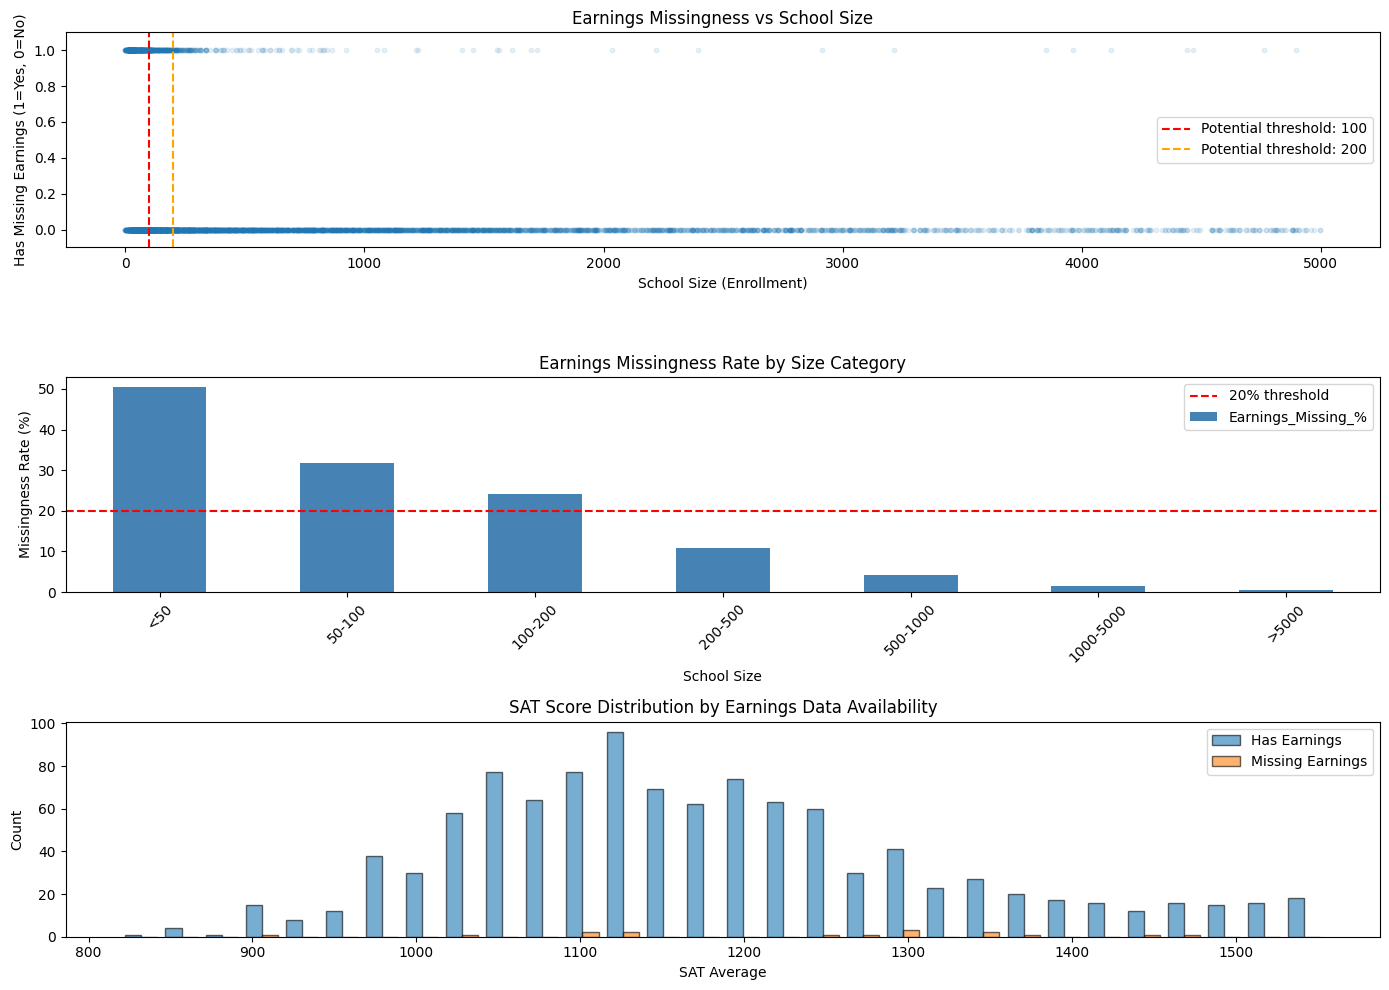

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

#Missingness by size
ax1 = axes[0]
df_plot = df[df['UGDS'].notna() & (df['UGDS'] < 5000)].copy()
ax1.scatter(df_plot['UGDS'], df_plot['earnings_missing'].astype(int), alpha=0.1, s=10)
ax1.axvline(x=100, color='red', linestyle='--', label='Potential threshold: 100')
ax1.axvline(x=200, color='orange', linestyle='--', label='Potential threshold: 200')
ax1.set_xlabel('School Size (Enrollment)')
ax1.set_ylabel('Has Missing Earnings (1=Yes, 0=No)')
ax1.set_title('Earnings Missingness vs School Size')
ax1.legend()
ax1.set_ylim(-0.1, 1.1)

#Missingness rate by size bins
ax2 = axes[1]
size_threshold['Earnings_Missing_%'].plot(kind='bar', ax=ax2, color='steelblue')
ax2.axhline(y=20, color='red', linestyle='--', label='20% threshold')
ax2.set_xlabel('School Size')
ax2.set_ylabel('Missingness Rate (%)')
ax2.set_title('Earnings Missingness Rate by Size Category')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

#SAT distribution by missingness
ax3 = axes[2]
sat_data_with = df[(df['earnings_missing']==False) & (df['SAT_AVG'].notna())]['SAT_AVG']
sat_data_without = df[(df['earnings_missing']==True) & (df['SAT_AVG'].notna())]['SAT_AVG']
ax3.hist([sat_data_with, sat_data_without], bins=30, label=['Has Earnings', 'Missing Earnings'], alpha=0.6, edgecolor='black')
ax3.set_xlabel('SAT Average')
ax3.set_ylabel('Count')
ax3.set_title('SAT Score Distribution by Earnings Data Availability')
ax3.legend()
plt.tight_layout()
plt.show()